In [267]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import h5py
from IPython.display import Audio
import librosa
import librosa.display
import random
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.preprocessing import LabelEncoder
from keras.utils import to_categorical
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from skimage.transform import resize

In [268]:
file_path = "/Users/nikhilghugare/Desktop/SML_ Practical 3/bird_spectrograms.hdf5"

with h5py.File(file_path, 'r') as f:
    keys = list(f.keys())
    print("Keys in file:")
    for key in keys:
        print(key)
        dataset = f[key]
        print("Shape:", dataset.shape)

Keys in file:
amecro
Shape: (128, 517, 66)
amerob
Shape: (128, 517, 172)
bewwre
Shape: (128, 517, 144)
bkcchi
Shape: (128, 517, 45)
daejun
Shape: (128, 517, 125)
houfin
Shape: (128, 517, 84)
houspa
Shape: (128, 517, 630)
norfli
Shape: (128, 517, 37)
rewbla
Shape: (128, 517, 187)
sonspa
Shape: (128, 517, 263)
spotow
Shape: (128, 517, 137)
whcspa
Shape: (128, 517, 91)


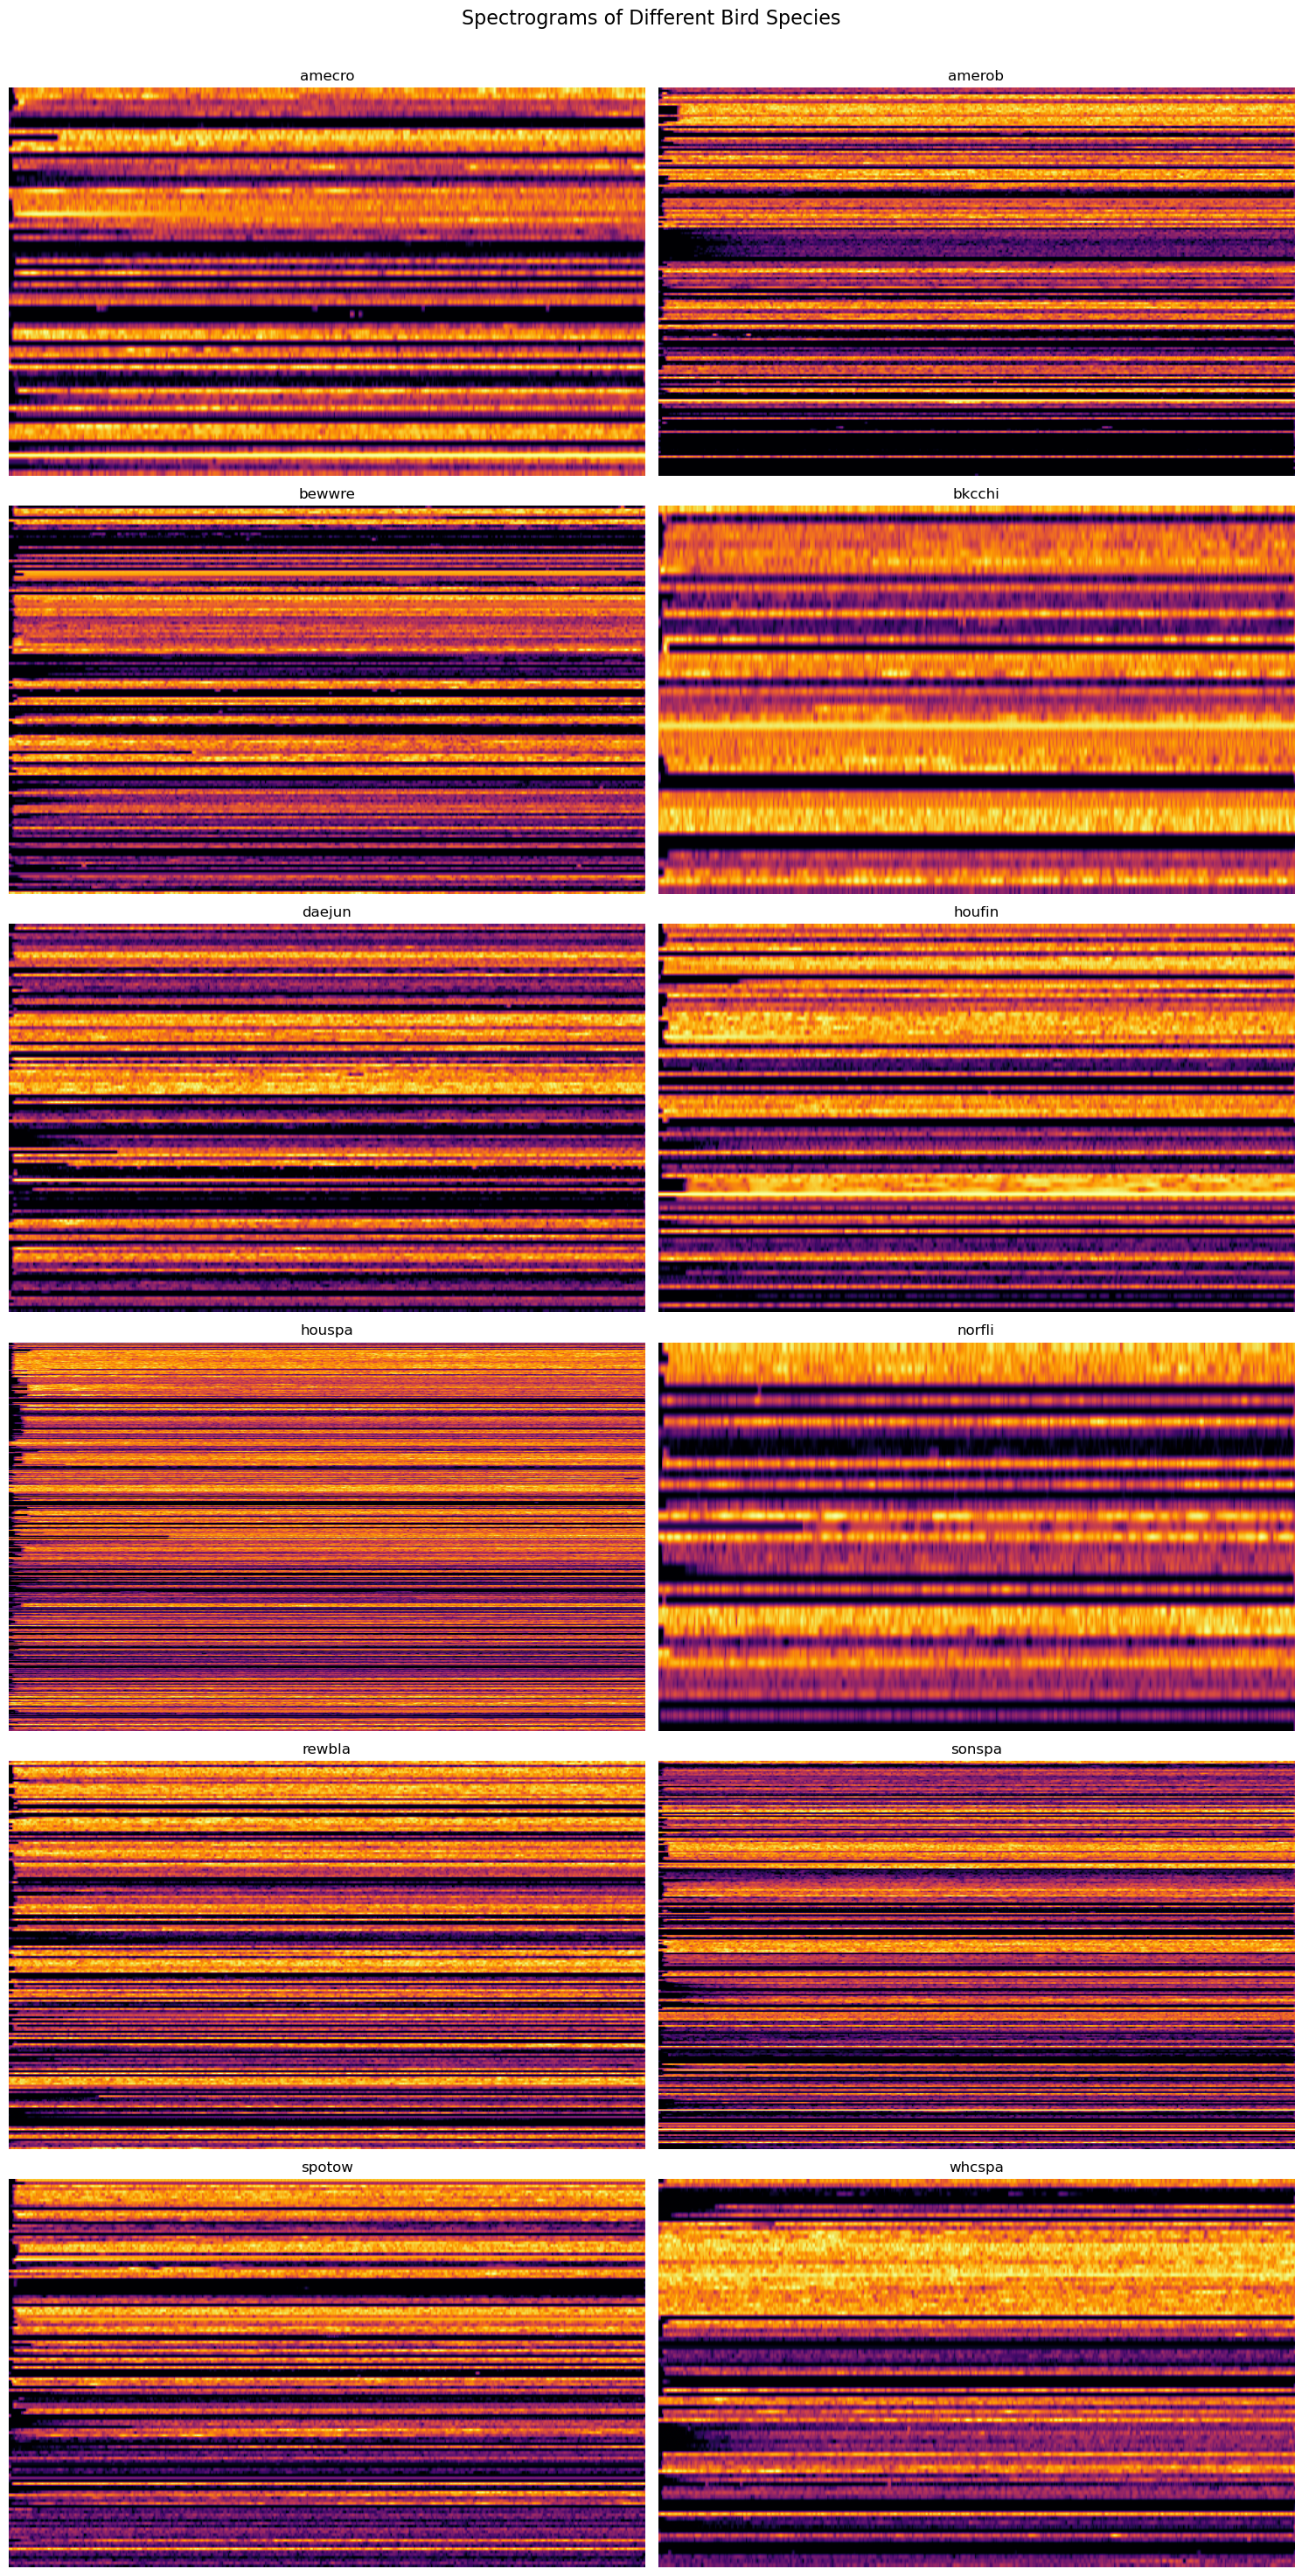

In [269]:
import h5py
import matplotlib.pyplot as plt

with h5py.File(file_path, 'r') as f:
    species_keys = list(f.keys())
    fig, axes = plt.subplots(nrows=6, ncols=2, figsize=(15, 30))
    fig.suptitle('Spectrograms of Different Bird Species', fontsize=16)

    for ax, key in zip(axes.flat, species_keys):
        dset = f[key]
        spectrogram = dset[0]
        ax.imshow(spectrogram.T, aspect='auto', origin='lower', cmap='inferno')
        ax.set_title(key)
        ax.axis('off')

    plt.tight_layout()
    plt.subplots_adjust(top=0.95)
    plt.show()


# Binary Classification

## Model 1 - Without Dropout Layer

In [272]:
import h5py
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
import tensorflow as tf

file_path = "/Users/nikhilghugare/Desktop/SML_ Practical 3/bird_spectrograms.hdf5"

with h5py.File(file_path, 'r') as f:
    species_list_new = list(f.keys())
    print(f"New Species list: {species_list_new}")

    amecro_data_new = f['amecro'][:]
    bewwre_data_new = f['bewwre'][:]

# Prepare labels
amecro_labels_new = np.zeros(amecro_data_new.shape[2])
bewwre_labels_new = np.ones(bewwre_data_new.shape[2])

# Combine and reshape
X_new = np.concatenate((amecro_data_new.transpose(2, 1, 0), bewwre_data_new.transpose(2, 1, 0)), axis=0)
y_new = np.concatenate((amecro_labels_new, bewwre_labels_new), axis=0)

# Train-test split
X_train_new, X_test_new, y_train_new, y_test_new = train_test_split(X_new, y_new, test_size=0.2, random_state=42)

# Reshape for logistic regression
nsamples_new, nx_new, ny_new = X_train_new.shape
X_train_reshaped_new = X_train_new.reshape((nsamples_new, nx_new * ny_new))

scaler_new = StandardScaler().fit(X_train_reshaped_new)
X_train_scaled_new = scaler_new.transform(X_train_reshaped_new)

nsamples_test_new, nx_test_new, ny_test_new = X_test_new.shape
X_test_reshaped_new = X_test_new.reshape((nsamples_test_new, nx_test_new * ny_test_new))
X_test_scaled_new = scaler_new.transform(X_test_reshaped_new)

# Reshape for CNN
X_train_scaled_cnn_new = X_train_scaled_new.reshape((nsamples_new, nx_new, ny_new, 1))
X_test_scaled_cnn_new = X_test_scaled_new.reshape((nsamples_test_new, nx_test_new, ny_test_new, 1))

# Logistic Regression
log_reg_new = LogisticRegression(random_state=123, max_iter=1000)
log_reg_new.fit(X_train_scaled_new, y_train_new)
y_pred_log_reg_new = log_reg_new.predict(X_test_scaled_new)
log_reg_accuracy_new = accuracy_score(y_test_new, y_pred_log_reg_new) * 100
print(f"Logistic Regression test accuracy: {log_reg_accuracy_new:.4f}%")

# CNN Model
np.random.seed(123)
tf.random.set_seed(123)

input_shape_new = X_train_scaled_cnn_new.shape[1:]  # Automatically get (nx, ny, 1)

bina_new_no_dropout = tf.keras.Sequential([
    tf.keras.layers.Input(shape=input_shape_new),
    tf.keras.layers.Conv2D(32, kernel_size=(3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
    tf.keras.layers.Conv2D(64, kernel_size=(3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

bina_new_no_dropout.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train CNN
history_no_dropout = bina_new_no_dropout.fit(
    X_train_scaled_cnn_new, y_train_new,
    validation_data=(X_test_scaled_cnn_new, y_test_new),
    epochs=10
)

New Species list: ['amecro', 'amerob', 'bewwre', 'bkcchi', 'daejun', 'houfin', 'houspa', 'norfli', 'rewbla', 'sonspa', 'spotow', 'whcspa']
Logistic Regression test accuracy: 83.3333%
Epoch 1/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 5s 752ms/step - accuracy: 0.6478 - loss: 7.3138 - val_accuracy: 0.7857 - val_loss: 6.0600
Epoch 2/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 3s 479ms/step - accuracy: 0.5510 - loss: 6.7092 - val_accuracy: 0.7381 - val_loss: 0.5325
Epoch 3/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 3s 599ms/step - accuracy: 0.8705 - loss: 0.2857 - val_accuracy: 0.9048 - val_loss: 0.2985
Epoch 4/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 3s 502ms/step - accuracy: 0.8863 - loss: 0.2904 - val_accuracy: 0.9048 - val_loss: 0.3107
Epoch 5/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 3s 443ms/step - accuracy: 0.9469 - loss: 0.1779 - val_accuracy: 0.9286 - val_loss: 0.2819
Epoch 6/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 3s 449ms/step - accuracy: 0.9740 - loss: 0.0829 - val_accuracy: 0.8810 - val_loss: 0.3072
Epoch 7/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 3s 563ms/step - accuracy:

In [273]:
test_loss_no_dropout, test_accuracy_no_dropout = bina_new_no_dropout.evaluate(X_test_scaled_cnn_new, y_test_new)
test_accuracy_no_dropout = test_accuracy_no_dropout * 100
print(f"CNN (without dropout) test accuracy: {test_accuracy_no_dropout:.4f}")
print(f"CNN (without dropout) test loss: {test_loss_no_dropout:.4f}")

train_loss_no_dropout = history_no_dropout.history['loss'][-1]
train_accuracy_no_dropout = history_no_dropout.history['accuracy'][-1] * 100
print(f"CNN (without dropout) train accuracy: {train_accuracy_no_dropout:.4f}")
print(f"CNN (without dropout) train loss: {train_loss_no_dropout:.4f}")

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - accuracy: 0.8631 - loss: 0.3515 
CNN (without dropout) test accuracy: 85.7143
CNN (without dropout) test loss: 0.3606
CNN (without dropout) train accuracy: 100.0000
CNN (without dropout) train loss: 0.0055


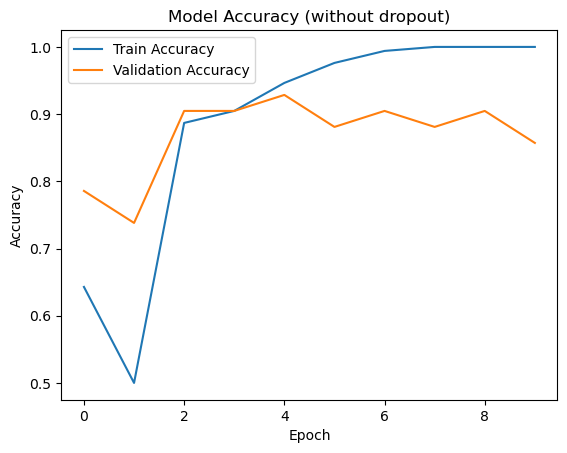

In [274]:
plt.plot(history_no_dropout.history['accuracy'], label='Train Accuracy')
plt.plot(history_no_dropout.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy (without dropout)')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc='upper left')

plt.show()

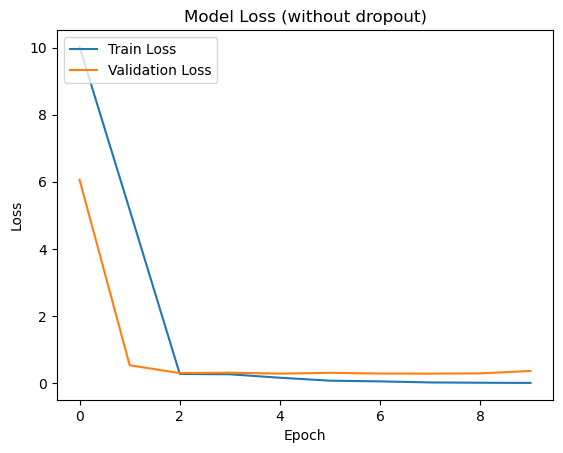

In [275]:
plt.plot(history_no_dropout.history['loss'], label='Train Loss')
plt.plot(history_no_dropout.history['val_loss'], label='Validation Loss')
plt.title('Model Loss (without dropout)')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper left')



## Model 2 - With Dropout Layer

In [277]:
np.random.seed(123)
tf.random.set_seed(123)

# CNN Model with Dropout
bina_new = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(nx_new, ny_new, 1)),
    tf.keras.layers.Conv2D(32, kernel_size=(3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
    tf.keras.layers.Conv2D(64, kernel_size=(3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

bina_new.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

history_new = bina_new.fit(X_train_scaled_cnn_new, y_train_new, validation_data=(X_test_scaled_cnn_new, y_test_new), epochs=10)

Epoch 1/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 5s 614ms/step - accuracy: 0.4836 - loss: 8.7079 - val_accuracy: 0.7857 - val_loss: 2.2136
Epoch 2/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 3s 530ms/step - accuracy: 0.6838 - loss: 2.7619 - val_accuracy: 0.8095 - val_loss: 0.4370
Epoch 3/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 3s 552ms/step - accuracy: 0.8726 - loss: 0.4040 - val_accuracy: 0.9048 - val_loss: 0.3561
Epoch 4/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 4s 573ms/step - accuracy: 0.8143 - loss: 0.4171 - val_accuracy: 0.8571 - val_loss: 0.2683
Epoch 5/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 3s 509ms/step - accuracy: 0.9073 - loss: 0.2725 - val_accuracy: 0.9048 - val_loss: 0.2730
Epoch 6/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 4s 592ms/step - accuracy: 0.9246 - loss: 0.2190 - val_accuracy: 0.9286 - val_loss: 0.2376
Epoch 7/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 3s 527ms/step - accuracy: 0.9288 - loss: 0.1646 - val_accuracy: 0.9286 - val_loss: 0.2474
Epoch 8/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 3s 586ms/step - accuracy: 0.9766 - loss: 0.1012 - val_accuracy: 0.9048 - val_loss:

In [278]:
test_loss_new, test_accuracy_new = bina_new.evaluate(X_test_scaled_cnn_new, y_test_new)
test_accuracy_new = test_accuracy_new * 100
test_loss_new = test_loss_new * 100
print(f"Test accuracy: {test_accuracy_new:.4f}")
print(f"Test loss: {test_loss_new:.4f}")

train_loss_new = history_new.history['loss'][-1]
train_accuracy_new = history_new.history['accuracy'][-1] * 100
train_loss_new = train_loss_new * 100
print(f"Train accuracy: {train_accuracy_new:.4f}")
print(f"Train loss: {train_loss_new:.4f}")

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - accuracy: 0.9211 - loss: 0.3184 
Test accuracy: 92.8571
Test loss: 29.4955
Train accuracy: 99.4048
Train loss: 4.5878


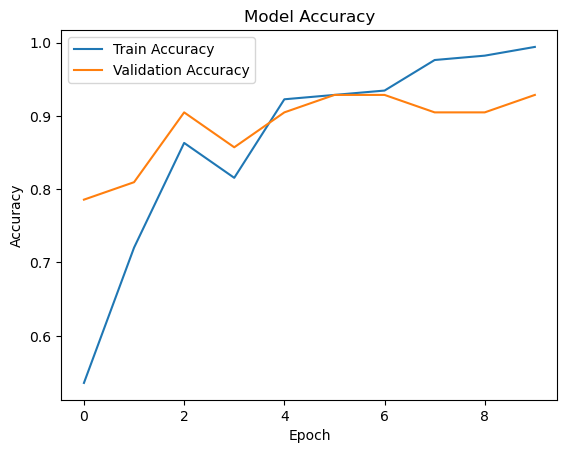

In [279]:

plt.plot(history_new.history['accuracy'], label='Train Accuracy')
plt.plot(history_new.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc='upper left')

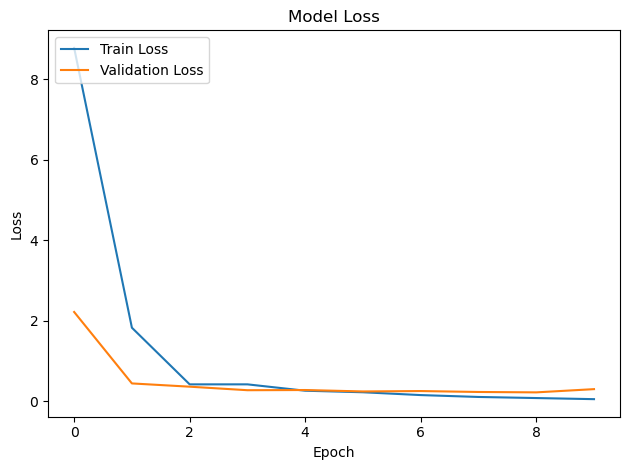

In [280]:

plt.plot(history_new.history['loss'], label='Train Loss')
plt.plot(history_new.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper left')

plt.tight_layout()
plt.show()

# Multi-Class

## Model 1 - without Dropout Layer

In [283]:
import h5py
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

# Load data
file_path = "/Users/nikhilghugare/Desktop/SML_ Practical 3/bird_spectrograms.hdf5"

with h5py.File(file_path, 'r') as f:
    species_names_multiclass = [
    'amecro',
    'amerob',
    'bewwre',
    'bkcchi',
    'daejun',
    'houspa',
    'houfin',
    'norfli',
    'rewbla',
    'sonspa',
    'spotow',
    'whcspa'
]
    data = []
    labels = []
    for species in species_names_multiclass:
        species_data = f[species][:]
        species_label = [species_names_multiclass.index(species)] * species_data.shape[2]
        data.append(species_data.transpose(2, 1, 0))
        labels.extend(species_label)
X = np.concatenate(data, axis=0)
y = np.array(labels)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train.reshape(X_train.shape[0], -1)).reshape(X_train.shape)
X_test_scaled = scaler.transform(X_test.reshape(X_test.shape[0], -1)).reshape(X_test.shape)
X_train_scaled = X_train_scaled[..., np.newaxis]
X_test_scaled = X_test_scaled[..., np.newaxis]

# Model 1 without Dropout
model1 = tf.keras.Sequential([
    tf.keras.layers.Input(shape=X_train_scaled.shape[1:]),
    tf.keras.layers.Conv2D(32, kernel_size=(3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
    tf.keras.layers.Conv2D(64, kernel_size=(3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dense(len(species_names_multiclass), activation='softmax')
])

model1.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

history1 = model1.fit(X_train_scaled, y_train, validation_data=(X_test_scaled, y_test), epochs=10)

Epoch 1/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 36s 698ms/step - accuracy: 0.2031 - loss: 10.7402 - val_accuracy: 0.2897 - val_loss: 2.2574
Epoch 2/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 40s 796ms/step - accuracy: 0.3204 - loss: 2.1761 - val_accuracy: 0.3350 - val_loss: 2.0774
Epoch 3/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 30s 600ms/step - accuracy: 0.3835 - loss: 1.8657 - val_accuracy: 0.3426 - val_loss: 1.9874
Epoch 4/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 29s 584ms/step - accuracy: 0.5214 - loss: 1.4704 - val_accuracy: 0.3577 - val_loss: 2.1020
Epoch 5/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 37s 730ms/step - accuracy: 0.7002 - loss: 0.9829 - val_accuracy: 0.3224 - val_loss: 2.6725
Epoch 6/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 37s 739ms/step - accuracy: 0.8466 - loss: 0.5935 - val_accuracy: 0.3678 - val_loss: 2.4087
Epoch 7/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 39s 766ms/step - accuracy: 0.9006 - loss: 0.3836 - val_accuracy: 0.3300 - val_loss: 3.2552
Epoch 8/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 35s 701ms/step - accuracy: 0.9562 - loss: 0.2081 - val_acc

In [284]:
test_loss1, test_accuracy1 = model1.evaluate(X_test_scaled, y_test)
test_accuracy1 = test_accuracy1 * 100
print(f"Model 1 Test accuracy: {test_accuracy1:.4f}")
print(f"Model 1 Test loss: {test_loss1:.4f}")

train_loss1 = history1.history['loss'][-1]
train_accuracy1 = history1.history['accuracy'][-1] * 100
print(f"Model 1 Train accuracy: {train_accuracy1:.4f}")
print(f"Model 1 Train loss: {train_loss1:.4f}")

13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 110ms/step - accuracy: 0.3956 - loss: 3.9068
Model 1 Test accuracy: 39.0428
Model 1 Test loss: 4.0759
Model 1 Train accuracy: 99.5581
Model 1 Train loss: 0.0351


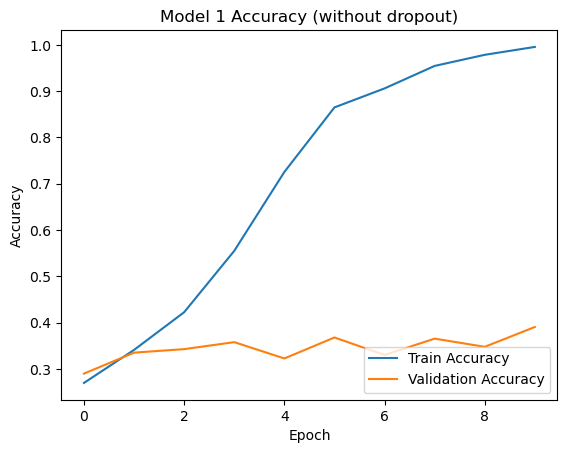

In [285]:
plt.plot(history1.history['accuracy'], label='Train Accuracy')
plt.plot(history1.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model 1 Accuracy (without dropout)')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc='lower right')

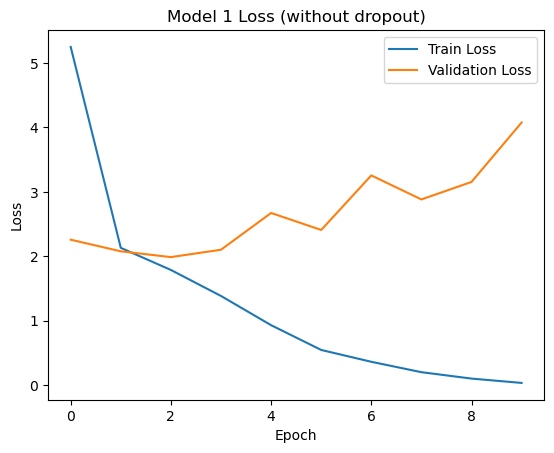

In [286]:
plt.plot(history1.history['loss'], label='Train Loss')
plt.plot(history1.history['val_loss'], label='Validation Loss')
plt.title('Model 1 Loss (without dropout)')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper right')

## Model2 - Adding Dropout Layer

In [288]:
# Model 2 with Dropout
model2 = tf.keras.Sequential([
    tf.keras.layers.Input(shape=X_train_scaled.shape[1:]),
    tf.keras.layers.Conv2D(32, kernel_size=(3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
    tf.keras.layers.Conv2D(64, kernel_size=(3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(len(species_names_multiclass), activation='softmax')
])

model2.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

history2 = model2.fit(X_train_scaled, y_train, validation_data=(X_test_scaled, y_test), epochs=10)

Epoch 1/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 44s 868ms/step - accuracy: 0.2058 - loss: 11.3879 - val_accuracy: 0.2897 - val_loss: 2.2564
Epoch 2/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 40s 786ms/step - accuracy: 0.3004 - loss: 2.2393 - val_accuracy: 0.2947 - val_loss: 2.2547
Epoch 3/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 42s 841ms/step - accuracy: 0.3180 - loss: 2.1665 - val_accuracy: 0.3098 - val_loss: 2.1709
Epoch 4/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 50s 984ms/step - accuracy: 0.3671 - loss: 1.9560 - val_accuracy: 0.3401 - val_loss: 2.0736
Epoch 5/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 36s 721ms/step - accuracy: 0.4493 - loss: 1.6597 - val_accuracy: 0.3526 - val_loss: 2.0153
Epoch 6/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 34s 678ms/step - accuracy: 0.6152 - loss: 1.2225 - val_accuracy: 0.3627 - val_loss: 2.1670
Epoch 7/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 33s 667ms/step - accuracy: 0.7429 - loss: 0.8087 - val_accuracy: 0.3804 - val_loss: 2.3725
Epoch 8/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 35s 708ms/step - accuracy: 0.8618 - loss: 0.4783 - val_acc

In [289]:
test_loss2, test_accuracy2 = model2.evaluate(X_test_scaled, y_test)
test_accuracy2 = test_accuracy2 * 100
print(f"Model 2 Test accuracy: {test_accuracy2:.4f}")
print(f"Model 2 Test loss: {test_loss2:.4f}")

train_loss2 = history2.history['loss'][-1]
train_accuracy2 = history2.history['accuracy'][-1] * 100
print(f"Model 2 Train accuracy: {train_accuracy2:.4f}")
print(f"Model 2 Train loss: {train_loss2:.4f}")

13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 114ms/step - accuracy: 0.4087 - loss: 2.8597
Model 2 Test accuracy: 39.0428
Model 2 Test loss: 3.0213
Model 2 Train accuracy: 94.0025
Model 2 Train loss: 0.2259


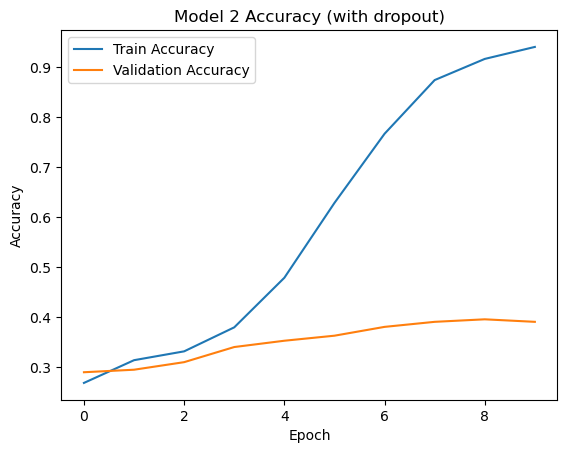

In [290]:
plt.plot(history2.history['accuracy'], label='Train Accuracy')
plt.plot(history2.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model 2 Accuracy (with dropout)')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc='upper left')

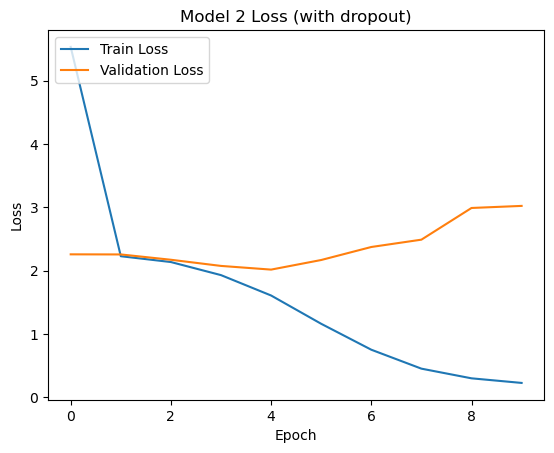

In [291]:
plt.plot(history2.history['loss'], label='Train Loss')
plt.plot(history2.history['val_loss'], label='Validation Loss')
plt.title('Model 2 Loss (with dropout)')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper left')

# Test

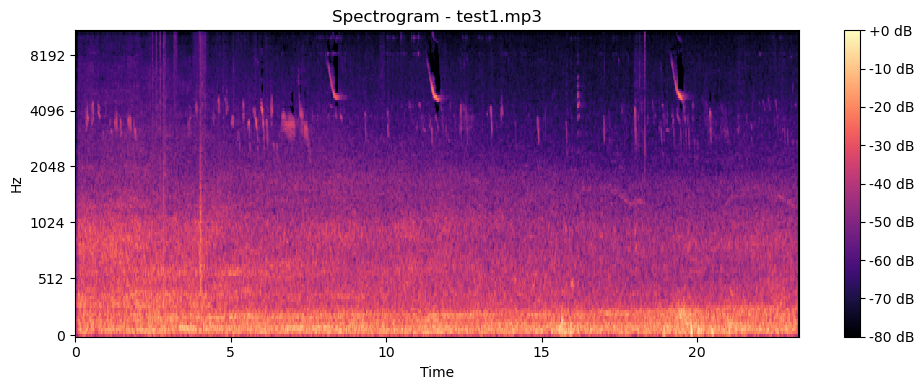

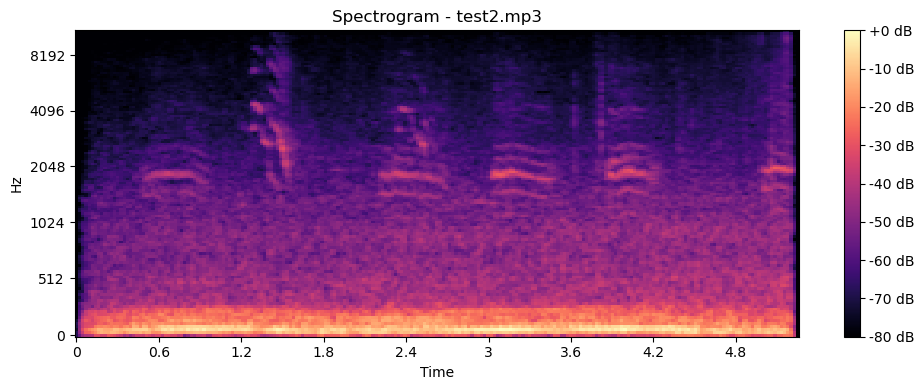

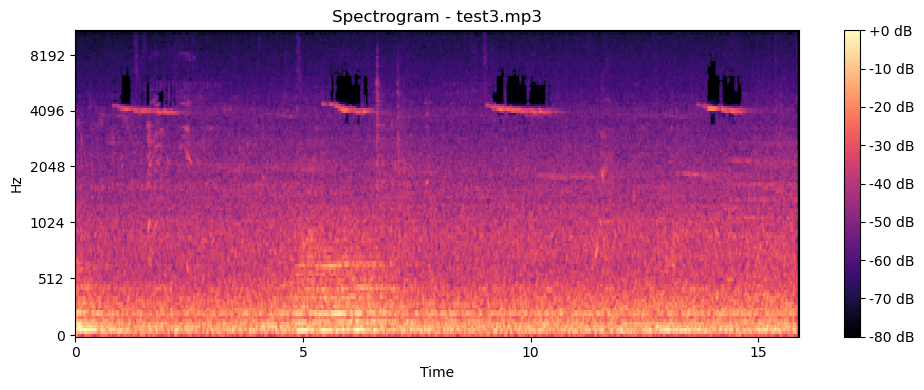

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step
Prediction for spectrogram 1: rewbla
Prediction for spectrogram 2: rewbla
Prediction for spectrogram 3: sonspa


In [293]:
import librosa
import librosa.display
import numpy as np
import matplotlib.pyplot as plt
from skimage.transform import resize
from sklearn.preprocessing import StandardScaler

def generate_spectrograms(audio_paths):
    spectrograms = []
    for audio_path in audio_paths:
        y, sr = librosa.load(audio_path)
        S = librosa.feature.melspectrogram(y=y, sr=sr)
        S_db = librosa.power_to_db(S, ref=np.max)
        spectrograms.append(S_db)

        plt.figure(figsize=(10, 4))
        librosa.display.specshow(S_db, sr=sr, x_axis='time', y_axis='mel')
        plt.colorbar(format='%+2.0f dB')
        plt.title('Spectrogram - ' + audio_path.split('/')[-1])
        plt.tight_layout()
        plt.show()
    return spectrograms

audio_paths = ["/Users/nikhilghugare/Desktop/SML_ Practical 3/test1.mp3",
               "/Users/nikhilghugare/Desktop/SML_ Practical 3/test2.mp3",
               "/Users/nikhilghugare/Desktop/SML_ Practical 3/test3.mp3"]

spectrograms = generate_spectrograms(audio_paths)

# Resize and standardize
desired_shape = (517, 128)
processed_spectrograms = [resize(s, desired_shape, anti_aliasing=True) for s in spectrograms]
spectrograms = np.array(processed_spectrograms)

spectrograms_flat = spectrograms.reshape(spectrograms.shape[0], -1)

# Fit scaler using training data (X_train)
X_train_flat = X_train.reshape(X_train.shape[0], -1)  # <- Make sure X_train is defined
scaler = StandardScaler()
scaler.fit(X_train_flat)

spectrograms_scaled_flat = scaler.transform(spectrograms_flat)
spectrograms_scaled = spectrograms_scaled_flat.reshape(spectrograms.shape)
spectrograms_scaled = spectrograms_scaled[..., np.newaxis]

# Predict
predictions = model2.predict(spectrograms_scaled)
predicted_indices = np.argmax(predictions, axis=1)
predicted_species = [species_names_multiclass[idx] for idx in predicted_indices]

for i, species in enumerate(predicted_species):
    print(f"Prediction for spectrogram {i + 1}: {species}")
